# Assignment 2: Training the Fully Recurrent Network

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.


## Exercise 1: Data generation

There are two classes, both occurring with probability 0.5. There is one input unit. Only the first sequence element conveys relevant information about the class. Sequence elements at positions $t > 1$ stem from a Gaussian with mean zero and variance 0.2. The first sequence element is 1.0 (-1.0) for class 1 (2). Target at sequence end is 1.0 (0.0) for class 1 (2)

Write a function `generate_data` that takes an integer `T` as argument which represents the sequence length. Seed the `numpy` random generator with the number `0xDEADBEEF`. Implement the [Python3 generator](https://docs.python.org/3/glossary.html#term-generator) pattern and produce data in the way described above. The input sequences should have the shape `(T, 1)` and the target values should have the shape `(1,)`.

In [53]:
%matplotlib inline
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

class FullyRecurrentNetwork(object):
    def __init__(self, D, I, K):
        self.W = np.random.uniform(-0.01, 0.01, (I, D))
        self.R = np.random.uniform(-0.01, 0.01, (I, I))
        self.V = np.random.uniform(-0.01, 0.01, (K, I))
    
    def forward(self, x, y):
        # helper function for numerically stable loss
        def f(z):
            return np.log1p(np.exp(-np.absolute(z))) + np.maximum(0, z)
        
        # infer dims
        T, D = x.shape
        K, I = self.V.shape

        # init result arrays
        self.x = x
        self.y = y
        self.a = np.zeros((T, I))
        self.s = np.zeros((T, I))

        # iterate forward in time 
        # trick: access model.a[-1] in first iteration
        for t in range(T):
            self.s[t] = self.W @ x[t] + self.R @ self.a[t-1]
            self.a[t] = np.tanh(self.s[t])
            
        self.z = self.V @ self.a[t]
        loss = y * f(-self.z) + (1-y) * f(self.z)
        return loss

T, D, I, K = 10, 3, 5, 1
model = FullyRecurrentNetwork(D, I, K)
model.forward(np.random.uniform(-1, 1, (T, D)), 1)

def generate_data(T, seed=0xDEADBEEF):
    np.random.seed(seed)
    while True:
        class_elem = np.random.binomial(1, p=0.5, size=(1,))
        x = np.random.normal(0, np.sqrt(0.2), size=(T,1))
        x[0] = class_elem
        yield x, np.array([1.]) if class_elem == 1. else np.array([0.])

data = generate_data(3)

## Exercise 2: Gradients for the network parameters
Compute gradients of the total loss 
$$
L = \sum_{t=1}^T L(t), \quad \text{where} \quad L(t) = L(z(t), y(t))
$$
w.r.t. the weights of the fully recurrent network. To this end, find the derivative of the loss w.r.t. the logits and hidden pre-activations first, i.e., 
$$
\psi^\top(t) = \frac{\partial L}{\partial z(t)} \quad \text{and} \quad \delta^\top(t) = \frac{\partial L}{\partial s(t)}.
$$
With the help of these intermediate results you should be able to compute the gradients w.r.t. the weights, i.e., $\nabla_W L, \nabla_R L, \nabla_V L$. 

*Hint: Take a look at the computational graph from the previous assignment to see the functional dependencies.*

*Remark: Although we only have one label at the end of the sequence, we consider the more general case of evaluating a loss at every time step in this exercise (many-to-many mapping).*

########## YOUR SOLUTION HERE ##########

+ 1) From Ass 1 we know the derivative of the loss:
$$\frac{\partial}{\partial z(t)} L(z(t),y(t))=\frac{1}{1+e^{-z(t)}}-y(t)$$

$$
\begin{align*}
\frac{\partial}{\partial z(t)} L&= \frac{\partial}{\partial z(t)}\sum\limits_{\tau=1}^{T}L(z(\tau),y(\tau))\\
&= \frac{\partial}{\partial z(t)}L(z(t),y(t))\\
&= \sigma(z(t))-y(t) = \psi(t)^{\top}
\end{align*}
$$


+ 2) Similar to 2.12
$$
\begin{align*}
\delta^{\top}(t) &=  \frac{\partial L}{\partial s(t)}\\
&= \frac{\partial L}{\partial a(t)}\frac{\partial a(t)}{\partial s(t)}\\
&= \left(\frac{\partial L(y(t),z(t))}{\partial a(t)}+\frac{\partial L}{\partial s(t+1)}\frac{\partial s(t+1)}{\partial a(t)}\right)\frac{\partial a(t)}{\partial s(t)}\\
&= \left(\frac{\partial L}{\partial z(t)}\frac{\partial z(t)}{\partial a(t)}+\delta(t+1)^{\top}R\right)\frac{\partial a(t)}{\partial s(t)}\\
&= \left(\psi(t)^{\top}V+\delta(t+1)^{\top}R\right)f'(s(t))
\end{align*}
$$

+ 3) From 2.18, 2.19 and 2.20 we get the Outer Product Representation
$$
\begin{align*}
\frac{\partial L}{\partial V} &= \sum\limits_{t=1}^{T}\psi(t)a(t)^\top\\
\frac{\partial L}{\partial R}&= \sum\limits_{t=1}^{T}\delta(t)a(t-1)^\top\\
\frac{\partial L}{\partial W}&= \sum\limits_{t=1}^{T}\delta(t)x(t)^\top
\end{align*}
$$

## Exercise 3: The backward pass
Write a function `backward` that takes a model `self` as argument. The function should compute the gradients of the loss with respect to all model parameters and store them to `self.dW`, `self.dR`, `self.dV`, respectively. 

In [54]:
def tanh_deriv(x):
        return 1 - np.tanh(x)**2
    
def backward(self):
    ########## YOUR SOLUTION HERE ##########
    # Calculation of psi, Last element has a value for z
    psi = np.zeros(((len(self.x),) + self.z.shape))
    psi[-1] = sigmoid(self.z) - self.y
    #print(sigmoid(self.z), self.y)
    
    # Calculation of delta. Setting last element first, as it's the only psi, and all others depend on the next one.
    delta = np.ones(self.s.shape)
    delta[-1] = np.dot(psi[-1], self.V) * tanh_deriv(self.s[-1])
    T_idx = len(delta) - 1
    #print(self.s[-1])
    
    self.dR = np.zeros_like(self.R)
    self.dW = np.zeros_like(self.W)
    self.dV = np.dot(psi[np.newaxis, -1], self.a[np.newaxis, -1])
    
    for t in range(1, len(delta)): 
        delta[T_idx-t] = (delta[T_idx-t+1] @ self.R) * tanh_deriv(self.s[-1])
    
    a_t = None
    
    for t in range(self.x.shape[0]):
        # np.dot() doesn't work here
        self.dW += delta[np.newaxis, t].T @ self.x[np.newaxis, t] 

        if t > 0:
            a_t = self.a[np.newaxis, t-1]
        else:
            a_t = np.zeros((1,)+self.a.shape[1:])
            
        self.dR += delta[np.newaxis, t].T @ a_t


FullyRecurrentNetwork.backward = backward
model.backward()

## Exercise 4: Gradient checking
Write a function `grad_check` that takes a model `self`, a float `eps` and another float `thresh` as arguments and computes the numerical gradients of the model parameters according to the approximation
$$
f'(x) \approx \frac{f(x + \varepsilon) - f(x - \varepsilon)}{2 \varepsilon}.
$$
If any of the analytical gradients are farther than `thresh` away from the numerical gradients the function should throw an error. 

In [63]:
def grad_check(self, eps, thresh):
    ########## YOUR SOLUTION HERE ##########
    param = (self.W, self.R, self.V)
    grads = (self.dW, self.dR, self.dV)
    
    for p, g in zip(param, grads):
        for i in range(p.shape[0]):
            for j in range(p.shape[1]):
                temp = p[i, j]
                p[i,j] = temp + eps
                loss0 = self.forward(self.x, 1)
                loss1 = self.forward(self.x, 1)
                p[i, j] = temp
                grad = (loss0 - loss1) / (2*eps)
                err = np.abs(grad - g[i,j])
                assert(err<thresh)
                
FullyRecurrentNetwork.grad_check = grad_check
model.grad_check(1e-7, 1e-7)

## Exercise 5: Parameter update

Write a function `update` that takes a model `self` and a float argument `eta`, which represents the learning rate. The method should implement the gradient descent update rule $\theta \gets \theta - \eta \nabla_{\theta}L$ for all model parameters $\theta$.

In [56]:
def update(self, eta):
    ########## YOUR SOLUTION HERE ##########
    self.W -= eta * self.dW
    self.R -= eta * self.dR
    self.V -= eta * self.dV

FullyRecurrentNetwork.update = update
model.update(0.001)

## Exercise 6: Network training

Train the fully recurrent network with 32 hidden units. Start with input sequences of length one and tune the learning rate and the number of update steps. Then increase the sequence length by one and tune the hyperparameters again. What is the maximal sequence length for which the fully recurrent network can achieve a performance that is better than random? Visualize your results. 

In [57]:
########## YOUR SOLUTION HERE ##########
def train(max_updates=2000):
    def softmax(z):
        return np.log1p(np.exp(-np.absolute(z))) + np.maximum(0, z)
    
    sequence_length = 1
    while True:
        num_updates = 0
        lr = 0.0001
        model = FullyRecurrentNetwork(D=1, I=32, K=1)
        losses, accuracies, lrs = list(), list(), list()
        data = generate_data(sequence_length)
        
        while True:
            x, y = next(data)

            loss = model.forward(x, y)
            losses.append(loss)
                            
            if num_updates % 500 == 0:
                lr *= 10
                
            model.backward()
            model.update(lr)
            lrs.append(lr)
            num_updates += 1
            
            # take loss < 0.3 as convergent
            if loss < 0.3:
                yield sequence_length, num_updates, losses, lrs
                break

            if num_updates >= max_updates:
                return
            
        sequence_length += 1

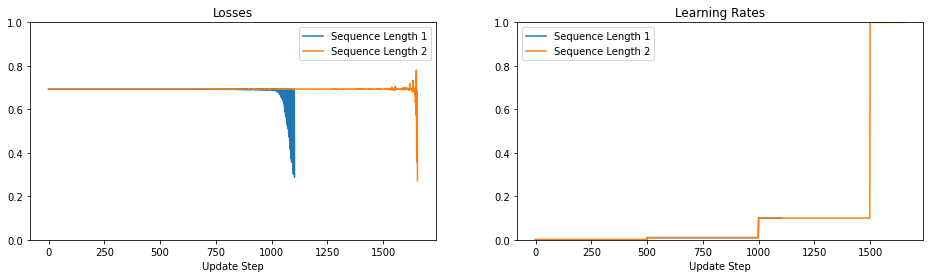

In [58]:
training_generator = train()
fig, axs = plt.subplots(1, 2, figsize=(16,4))

axs[0].set_title("Losses")
axs[0].set_ylim(0,1)
axs[0].set_xlabel("Update Step")

axs[1].set_title("Learning Rates")
axs[1].set_ylim(0,1)
axs[1].set_xlabel("Update Step")

for sequence_length, num_updates, losses, lrs in training_generator:
    axs[0].plot(losses, label=f"Sequence Length {sequence_length}")
    axs[1].plot(lrs, label=f"Sequence Length {sequence_length}")

axs[0].legend()
axs[1].legend()

plt.show()

## Exercise 7: The Vanishing Gradient Problem

Analyze why the network is incapable of learning long-term dependencies. Show that $\|\frac{\partial a(T)}{\partial a(1)}\|_2 \leq \|R\|_2^{T-1}$ , where $\|\cdot\|_2$ is the spectral norm, and discuss how that affects the propagation of error signals through the time dimension of the network. 

*Hint: Use the fact that the spectral norm is submultiplicative for square matrices, i.e. $\|AB\|_2 \leq \|A\|_2\|B\|_2$ if $A$ and $B$ are both square.*

+ 1) We have that:
$$
\begin{align*}
\frac{\partial a(t)}{\partial a(t-1)}&= \frac{\partial f(W^{\top}x(t)+R^{\top}a(t-1))}{\partial a(t-1)}R\\
&= \frac{\partial f(Wx(t)+Ra(t-1))}{\partial a(t-1)}R\\
&= f'(Wx(t)+Ra(t-1))R
\end{align*}
$$

+ 2) By using chain rule:
$$
\begin{align*}
\frac{\partial a(T)}{\partial a(1)} &= \frac{\partial a(T)}{\partial a(T-1)}\frac{\partial a(T-1)}{\partial a(T-2)}\ldots\frac{\partial a(2)}{\partial a(1)}\\
&= f'(Wx(T)+Ra(T-1))R\cdot f'(Wx(T-1)+Ra(T-2))R \ldots f'(Wx(2)+Ra(1))R\\
&= R^{T-1}\prod_{\tau=0}^{T-1}f'(Wx(\tau)+Ra(\tau-1))
\end{align*}
$$

+ 3) First inequalitiy holds because $f'(x)\leq 1$ and the second inequalitiy holds from the submultiplicative property of the spectral norm with the square matrix

$$\|\frac{\partial a(T)}{\partial a(1)}\|_{2}=\quad \|R^{T-1}\prod_{\tau=0}^{T-1}f'(Wx(\tau)+Ra(\tau-1))\|_{2}\quad \leq \quad \|R^{T-1}\|_{2}\leq\|R\|^{T-1}_{2}$$